# Problem 3 - a simple 2D distribution

Here we will make some data for a population of pumpkins but we will make the mass a function of the number of zombies that spawn where the pumpkin grows.  We will make the data look like the mass of the red clump as a function of no. of zombies (clearly this is not a physically plausible problem, nonetheless a gradient has been chosen simply to represent this fictional problem).

First we make some distribution representing the number of zombies found to spawn in a particular location:

$Z_{\rm true} \sim \mathcal{N}(2.0, 0.1)$ 

The distribution of the masses of the pumpkins will be defined as:

$M_{\rm P} \sim \mathcal{N}(4.5 + ((Z - 1)/ 2), 0.3)$.

For now, assume we have some magic machine that is able to measure the masses of each pumpkin with an observational uncertainty of 0.6 magnitudes.  If we have $N$ pumpkins which we will label with the index $i = 1,2,..., N$ then the measured mass will be:

$M_{i, {\rm obs}} \sim \mathcal{N}(M_{i, {\rm true}}, 0.6)$.

and finally we have the observed no. of zombies near each pumpkin with an uncertainty as $0.05 \, \rm Z_{\odot}$: 

$Z_{\rm obs} = \mathcal{N}(Z_{\rm true}, 0.05)$

Let's set up this data.

/home/daniel/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


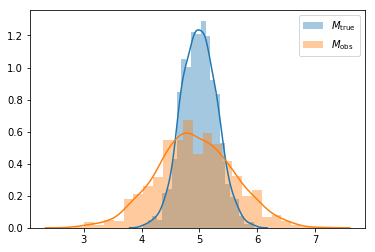

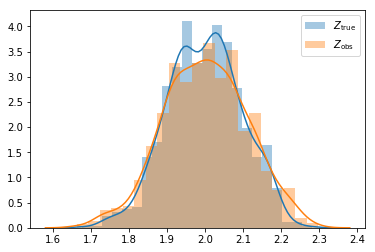

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

N = 1000
Zm = 2.0
Zs = 0.1
Msig = 0.3
alpha = 4.5
betainv = 1.0/2.0
Z_true = np.random.randn(N) * Zs + Zm
M_true = np.random.randn(N) * Msig + (alpha + ((Z_true - 1)* betainv))
sigma_M_obs = np.ones(N) * 0.6
M_obs = M_true + np.random.randn(N) * sigma_M_obs
sigma_Z_obs = np.ones(N) * 0.05
Z_obs = Z_true + np.random.randn(N) * sigma_Z_obs                                     
ax = sns.distplot(M_true, label=r'$M_{\rm true}$')
ax = sns.distplot(M_obs, label=r'$M_{\rm obs}$')
ax.legend()
plt.show()
ax = sns.distplot(Z_true, label=r'$Z_{\rm true}$')
ax = sns.distplot(Z_obs, label=r'$Z_{\rm obs}$')
ax.legend()

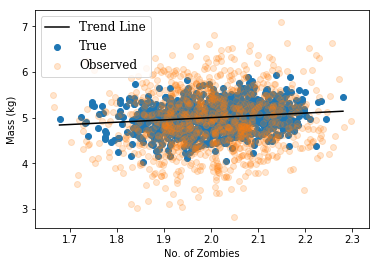

In [6]:
fig, ax = plt.subplots()
from matplotlib import rc
rc("font", family="serif", size=12)
ax.scatter(Z_true, M_true, label='True')
ax.scatter(Z_obs, M_obs, alpha=0.2, label='Observed')
MM = np.linspace(min(Z_true), max(Z_true), 100)
ax.plot(MM, alpha + (MM - 1) * betainv, 'k-', label='Trend Line')
ax.set_xlabel('No. of Zombies')
ax.set_ylabel('Mass (kg)')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of masses for the pumpkins from the observed data just by measuring the standard deviation we would find an overestimate and would not get any information about dependence upon the number of associated spawning zombies.

In [96]:
print(f'Observed data: mean = {M_obs.mean():.4f}; std = {M_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {M_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {M_true.mean():.4f}; std = {M_true.std(ddof=1):.4f};  ' +
      f'error on mean = {M_true.std(ddof=1) / N**0.5:.4f}')
print(f'Actual spread around the Mass relation {Msig}')

Observed data: mean = 4.9939; std = 0.6802; error on mean = 0.0215
True data: mean = 5.0123; std = 0.3014;  error on mean = 0.0095
Actual spread around the Mass relation 0.3


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  

Let's jump right in a build an acyclic graph to visualise our problem:

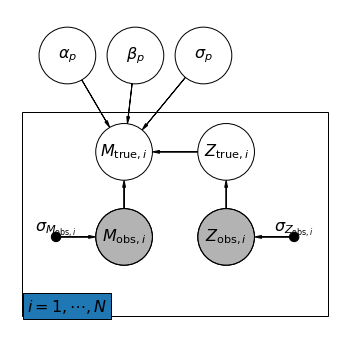

In [97]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha_{p}$", 0.5, 2.6))
pgm.add_node(daft.Node("beta", r"$\beta_{p}$", 1.1, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{p}$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("M_true", r"$M_{{\rm true},i}$", 1, 1.75))
pgm.add_node(daft.Node("Z_true", r"$Z_{{\rm true},i}$", 1.9, 1.75))
# Data.
pgm.add_node(daft.Node("M_obs", r"$M_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Merr", r"$\sigma_{M_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
pgm.add_node(daft.Node("Z_obs", r"$Z_{{\rm obs},i}$", 1.9, 1, observed=True))
pgm.add_node(daft.Node("Zerr", r"$\sigma_{Z_{{\rm obs},i}}$", 2.5, 1.0, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("alpha", "M_true")
pgm.add_edge("beta", "M_true")
pgm.add_edge("sigma", "M_true")
pgm.add_edge("Z_true", 'M_true')
pgm.add_edge("Z_obs", "Z_true")
pgm.add_edge("Zerr", "Z_obs")
pgm.add_edge("M_obs", "M_true")
pgm.add_edge("Merr", "M_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The masses of the pumpkins are assumed to follow a zombie abundance relation with a spread from a Gaussian distribution.  The parameters for the relation and the spread are unknown.  Each pumpkin in $N$ has an index $i$.  Each pumpkin also has a true mass and true number of zombies spawning in its vicinity, which are unknowns, and an observed mass and observed spawn number which are known with some uncertainty $\sigma_{M_{{\rm obs},i}}$, and $\sigma_{Z_{{\rm obs},i}}$.  We then treat $\alpha$, $\beta$, $\sigma$, , $[M_{{\rm true}, 1}, M_{{\rm true}, 2}, ..., M_{{\rm true}, N}]$, and $[Z_{{\rm true}, 1}, Z_{{\rm true}, 2}, ..., Z_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$M_{\rm true} \sim \mathcal{N}(M_{\rm obs}, \sigma_{M_{{\rm obs}}})$.

$Z_{\rm true} \sim \mathcal{N}(Z_{\rm obs}, \sigma_{Z_{{\rm obs}}})$.

That is, the true values of the pumpkin mass must be consistent with the observed values and their uncertainties.

$M_{\rm true} \sim \mathcal{N}(\alpha + (Z_{true} - 1)/\beta, \sigma)$.


We will also add the following priors that represent our exisiting knowledge of the pumpkins, but are designed to be weakly informative:

$\alpha \sim \mathcal{N}\left({4.5, 0.6}\right)$,

$\beta \sim \mathcal{N}(1/3, 1)$,

and 

$\sigma \sim {}\rm Lognormal(\log(0.8), 0.8)$. 

We can code this up in stan easily!

In [3]:
code = '''
data {
    int N;  // N stars
    real Mobs[N];
    real sigmaMobs[N];
    vector[N] Zobs;
    real sigmaZobs[N];
}
parameters {
    real ln_alpha;
    real<lower = 0> ln_beta;
    real<lower = 0> sigma;
    real Mtrue[N];
    vector[N] Ztrue;
}
transformed parameters{
    real alpha = exp(ln_alpha);
    real beta = exp(ln_beta);

}
model {
    Mtrue ~ normal(Mobs, sigmaMobs);
    Mtrue ~ normal(alpha + ((Ztrue - 1.0) / beta), sigma);
    Ztrue ~ normal(Zobs, sigmaZobs);
    alpha ~ normal(4.5, 0.6);
    beta ~ normal(2, 1.0);
    sigma ~ lognormal(log(0.8), 0.8);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03407bf02f182a1eccec24f3f4f1a339 NOW.


We can now run the code.

In [7]:
nchains = 4
data = {'N': N,
       'Mobs': M_obs,
       'sigmaMobs': sigma_M_obs,
       'Zobs': Z_obs,
       'sigmaZobs': sigma_Z_obs}
fit = sm.sampling(data=data, iter=2000, chains=nchains)

Running the code is simple.  

You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took 60 seconds.

We can print the fit object to see lots of useful information.  Perhaps most importantly, R_hat gives a measure of convergence.  The closer R_hat is to unity the better.  Experience suggests that all R_hat's less than 1.02 should give reasonable results.

In [8]:
print(fit)

Inference for Stan model: anon_model_03407bf02f182a1eccec24f3f4f1a339.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ln_alpha      1.48  1.0e-3   0.03   1.41   1.46   1.48    1.5   1.53   1070    1.0
ln_beta       0.65  8.0e-3   0.27   0.17   0.46   0.64   0.83   1.21   1128    1.0
sigma         0.28  3.3e-3   0.04   0.21   0.26   0.29   0.31   0.35    112   1.03
Mtrue[1]      4.98  2.8e-3   0.26   4.47   4.81   4.98   5.15    5.5   8391    1.0
Mtrue[2]      4.91  2.7e-3   0.25   4.42   4.74   4.91   5.08    5.4   9000    1.0
Mtrue[3]      5.13  3.1e-3   0.27   4.62   4.95   5.12    5.3   5.67   7488    1.0
Mtrue[4]      4.67  3.2e-3   0.27   4.13   4.49   4.67   4.85   5.19   6867    1.0
Mtrue[5]      4.85  2.9e-3   0.27   4.31   4.67   4.85   5.03   5.39   8608    1.0
Mtrue[6]      4.71  2.9e-3   0.26   4.19   4.53   4.71   4.88   

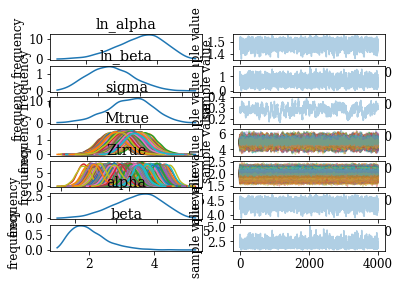

In [9]:
fit.plot()
rc("font", family="serif", size=12)
plt.show()

/home/daniel/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


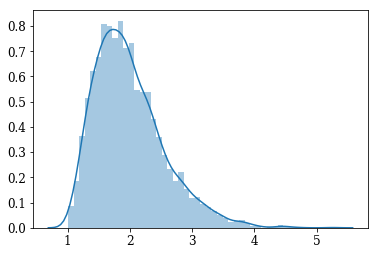

In [10]:
sns.distplot(fit['beta'])

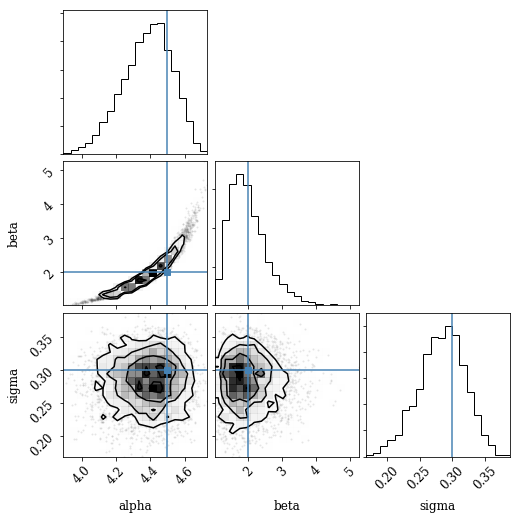

In [11]:
import corner
data = np.vstack([fit['alpha'], fit['beta'], fit['sigma']]).T
corner.corner(data, labels=['alpha', 'beta', 'sigma'], truths=[alpha, 1.0/betainv, Msig])
plt.show()

Comments TODO

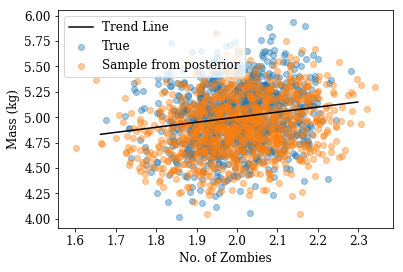

In [12]:
fig, ax = plt.subplots()
from matplotlib import rc
ax.scatter(Z_true, M_true, alpha=0.4, label='True')
ax.scatter(fit['Ztrue'][100, :], fit['Mtrue'][100,:], alpha=0.4, label='Sample from posterior')
MM = np.linspace(min(Z_obs), max(Z_obs), 100)
ax.plot(MM, alpha + (MM - 1) * betainv, 'k-', label='Trend Line')
ax.set_xlabel('No. of Zombies')
ax.set_ylabel('Mass (kg)')
ax.legend()

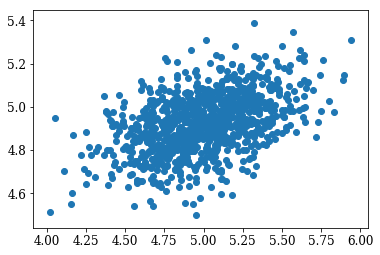

In [13]:
fig, ax = plt.subplots()
ax.scatter(M_true, fit['Mtrue'].mean(axis=0))